# Natural Gas Dataset
The natural gas dataset contains 834 observations of the week-to-week change in natural gas stocks, as well as eight additional predictor variables.

In [1]:
# Import libraries
import numpy as np
from numpy import genfromtxt
from matplotlib import pyplot as plt
from scipy.signal import savgol_filter
from numpy import linalg as lin
import seaborn as sns
import pandas as pd


# Import data
my_data = genfromtxt('../Data/natgas.data.csv', delimiter=',',dtype='f8')
my_data = my_data[1:,] # Ignore the first row, which contains headers

## Dataset Features
The variable to be forecast is the weekly change in natural gas stocks, over the course of several years. The time series exhibits roughly annual trends, where every 52 weeks a full period of behavior has been observed. In the throughs of the time series, there appears to be a greater variance than for the behavior on the plateaus.

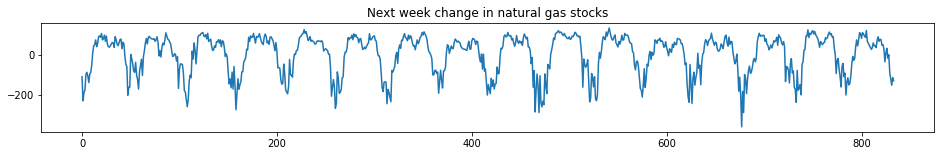

In [2]:
# Plot our target variable
plt.figure(figsize=(16, 2))
plt.plot(my_data[:,9])
plt.title('Next week change in natural gas stocks')
plt.show()

The first predictor variable is the current stock of natural gas. Differencing of this time series yields the target variable (week-to-week differences). Forecasts of heating/cooling days are the next two predictors. Finally, the last five features are the average temperatures recorded at five airports across the US.

All the aforementioned features have annual trends like the target variable. The heating/cooling day forecasts are not available until the 340th sample, and they include a few points of missing data thereafter, so models that include these two features need additional preprocessing to be fit.

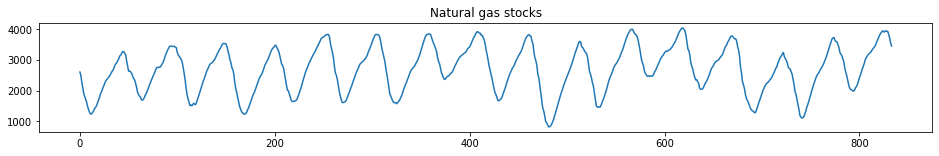

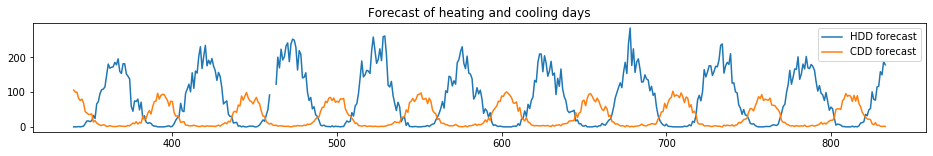

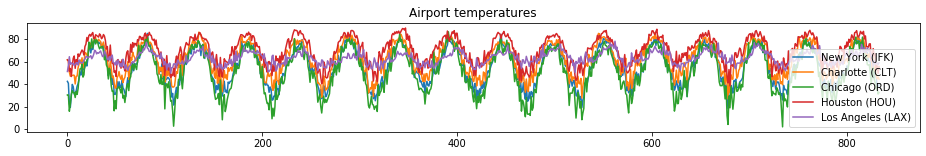

In [3]:
# Plot natural gas stocks
plt.figure(figsize=(16, 2))
plt.plot(my_data[:,1])
plt.title('Natural gas stocks')
plt.show()

# Plot heating/cooling days
plt.figure(figsize=(16, 2))
plt.plot(my_data[:,2:4])
plt.title('Forecast of heating and cooling days')
plt.legend(['HDD forecast','CDD forecast'])
plt.show()

# Plot airport temperatures
plt.figure(figsize=(16, 2))
plt.plot(my_data[:,4:9])
plt.title('Airport temperatures')
plt.legend(['New York (JFK)','Charlotte (CLT)','Chicago (ORD)','Houston (HOU)','Los Angeles (LAX)'])
plt.show()

## Marginal Distributions
A popular technique to visualize the correlations between factors in a multidimensional dataset is to use a pair-pair plot, where each row/column is a scatterplot or histogram to visualize the marginal distribution of either a feature or a pair of features from the higher dimensional sample distribution. From this form, we can already learn a great deal about trends in the data.

- **Seasonality** in the data becomes apparent when comparing a seasonal variable to something which a comparable seasonality. Comparing the current gas stock to most other variables produces a doughnut-shaped distribution, indicative that the two variables have a sinusoidal seasonality with different phases (in engineering, this is related to the theory of Lissajous figures.)
- **Strong relationships** can be observed between the heating and cooling day forecasts. Their joint PDF lies along a thin curve in the plane, in the shape of half a hyperbola. Since the heating and cooling forecasts features oscillations at opposing times in the above plots, you can see that the points like along either very vertical or very horizontal regions for part of the distribution. In general, data like this can be thought of as being very correlated in a nonlinear sense, and it suggest that fitting a manifold to their joint distribution could be a useful form of feature reduction.
- **Weaker relationships** can be observed amount the airport temperatures. The east-coast airports (JFK, CLT, ORD) are all strongly correlated, but this relationship weakens when we compare these airports to the more west airports (HOU, LAX). 
- **Stronger predictors** can be detected by looking at what variables more strongly correlated with the target variable. In this dataset, we see that the cooling day forecasts exhibit some nonlinear correlations with the target variable, which suggests that models that incorporate the CDD forecasts will likely perform better. In particular, the joint distribution appears to lie along a curve, so nonlinear methods that can adapt to the manifold may perform the best here.

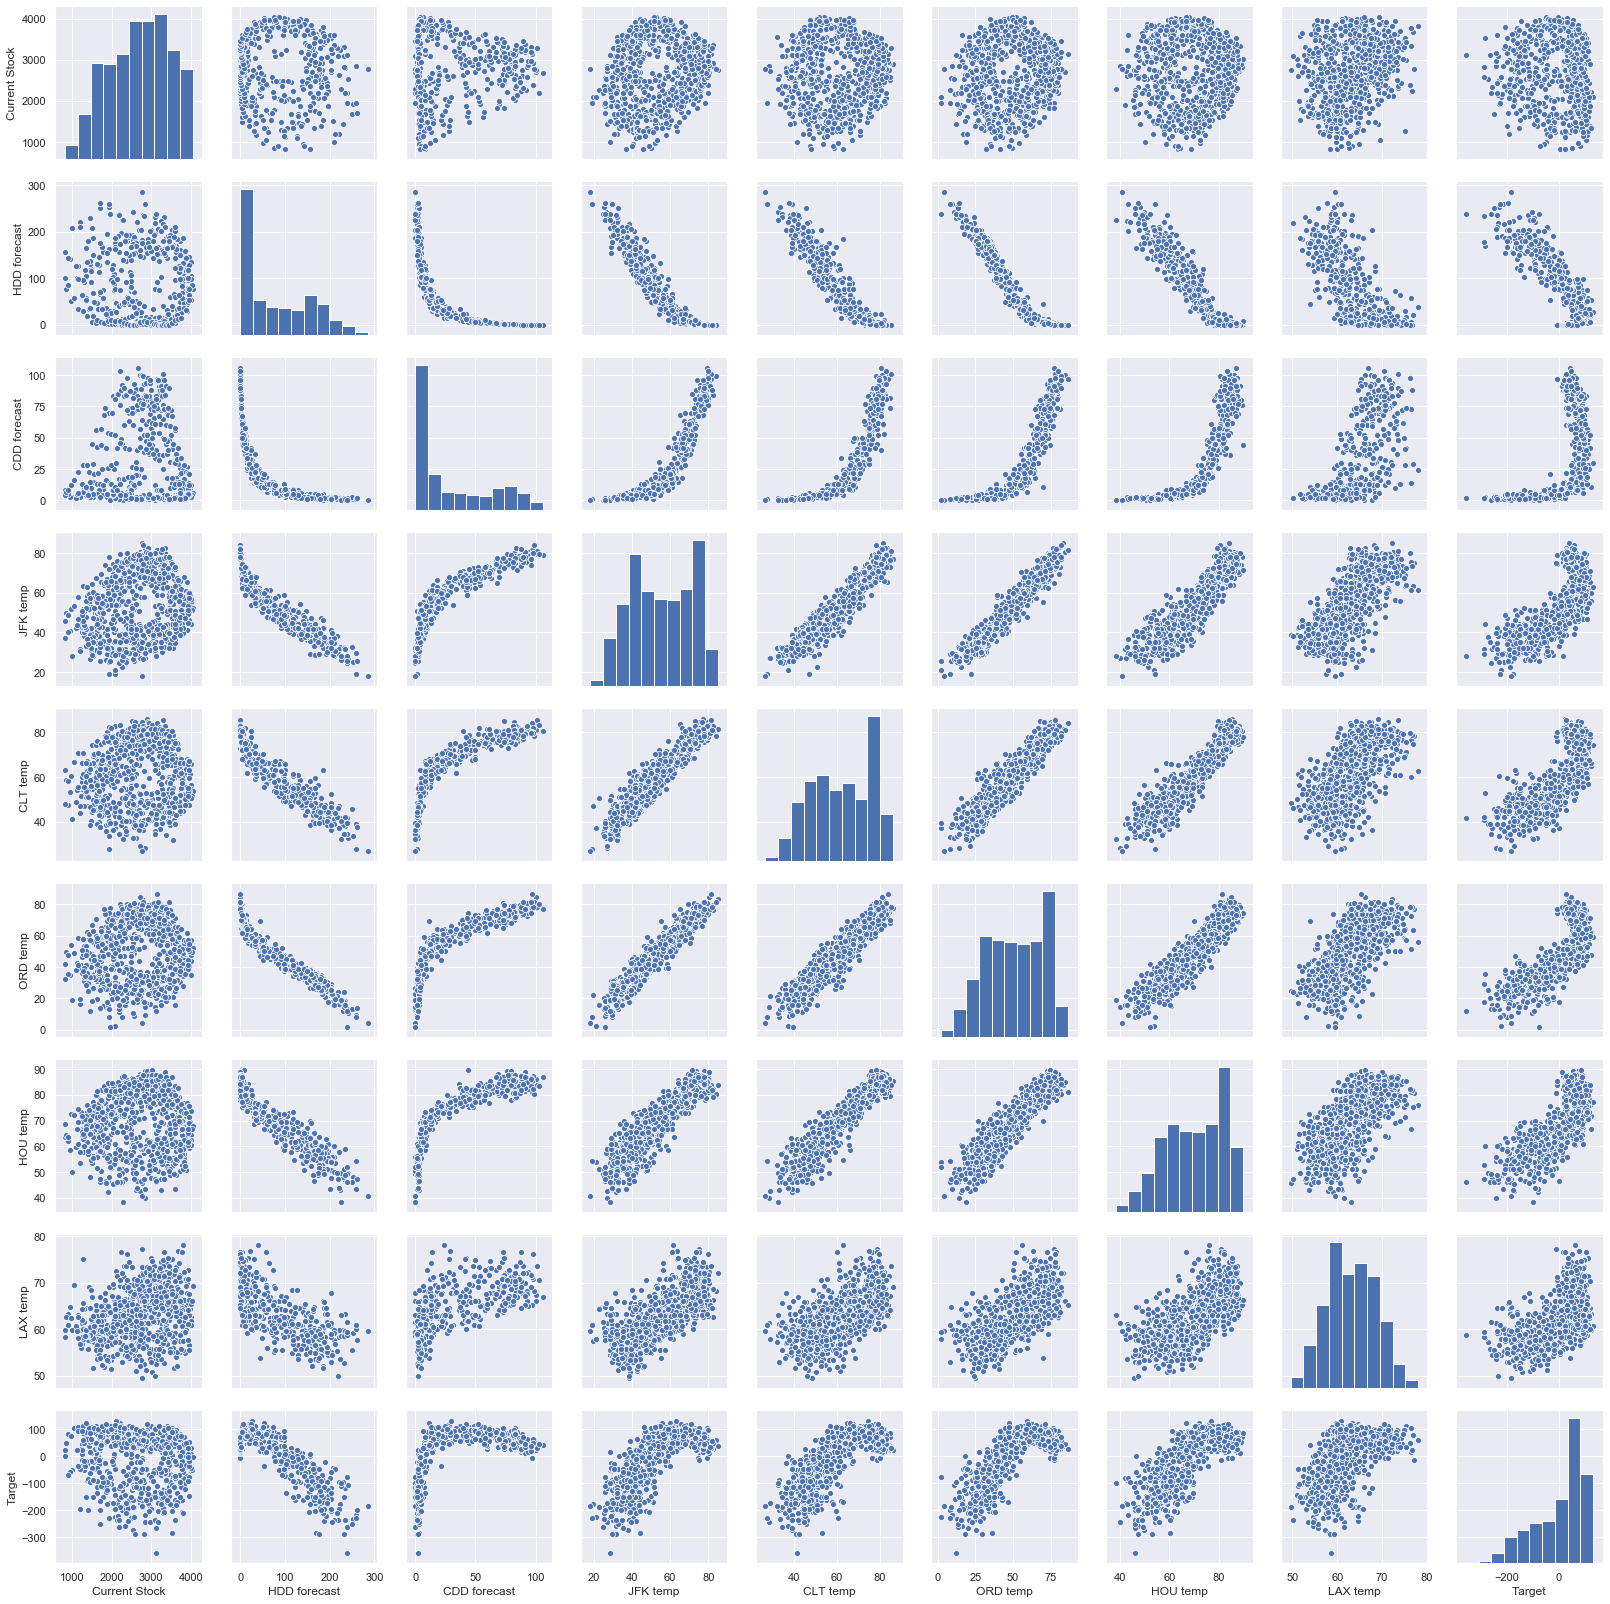

In [8]:
my_frame = pd.DataFrame(my_data[:,1:10],columns=['Current Stock','HDD forecast','CDD forecast','JFK temp','CLT temp','ORD temp','HOU temp','LAX temp','Target'])
sns.pairplot(my_frame, dropna=True)

## Deseasonalization
The seasonal trends are easy to predict, and if we do not separate them from the smaller data then we run the risk of assuming that we can forecast the process better than we really can. Further, seasonal trends that correspond to annual or other cyclical economic processes obfuscate the relationships between variables, since other cyclical economic variables may be confounding this process. Thus, for financial applications it is of interest to deseaonsalize the data and then check the resulting zero-mean processes for correlations.

To detrend our time series, we will use a Savitzky-Golay (SG) filter, which is a form of generalized weighted moving average. The SG filter will operate on each time series individually to detrend each signal. Deseasonlization of the stocks time series is difficult because it is very smooth, and detrending the heating/cooling days will require separate treatment from the full observed variables. For comparison, we will only show the last few features:

```python
my_data[:,4:9] # Airport temperatures. JFK, CLT, ORD, HOU, LAX in order.
my_data[:,9]   # Target variable. Week-to-week changes in gas stocks.
```

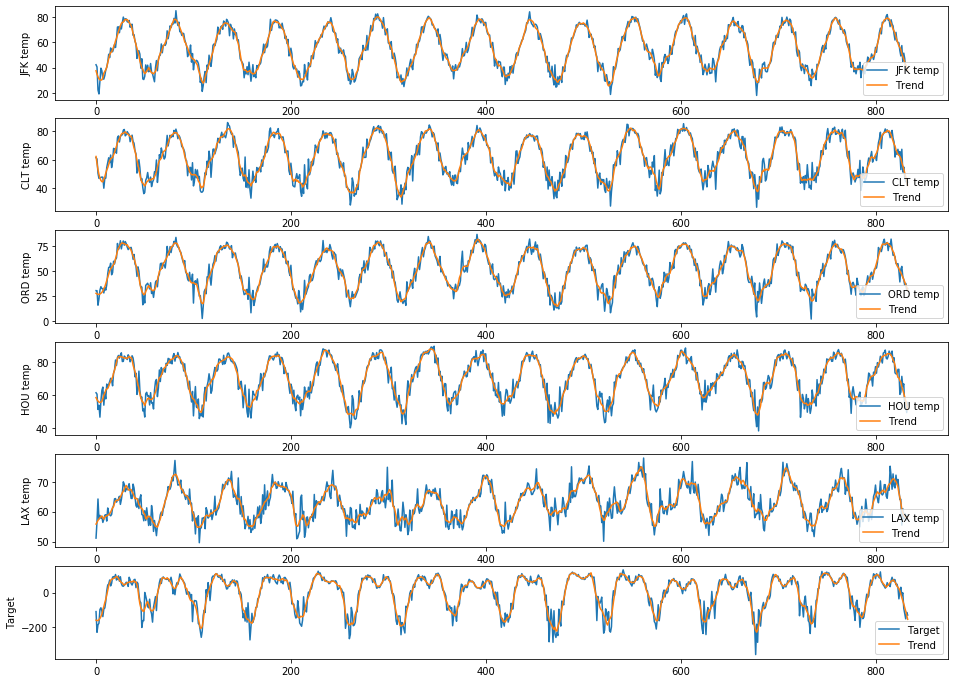

In [5]:
# Filter the data
window_length = 13
polyorder = 2
datatrend = savgol_filter(my_data[:,4:10], window_length, polyorder, axis=0)

# Produce a time variable
weeks = np.arange(0,datatrend.shape[0])

# Plot the trend fits
plt.figure(figsize=(16, 12))
names = ["JFK temp","CLT temp","ORD temp","HOU temp","LAX temp","Target"]
for k in range(0,6):
    plt.subplot(6,1,k+1)
    plt.plot(weeks, my_data[:,4+k],weeks, datatrend[:,k])
    plt.legend([names[k],'Trend'], loc='lower right')
    plt.ylabel(names[k])
plt.show()

To detrend the data then, we simply subtract each trend from it's associated signal.

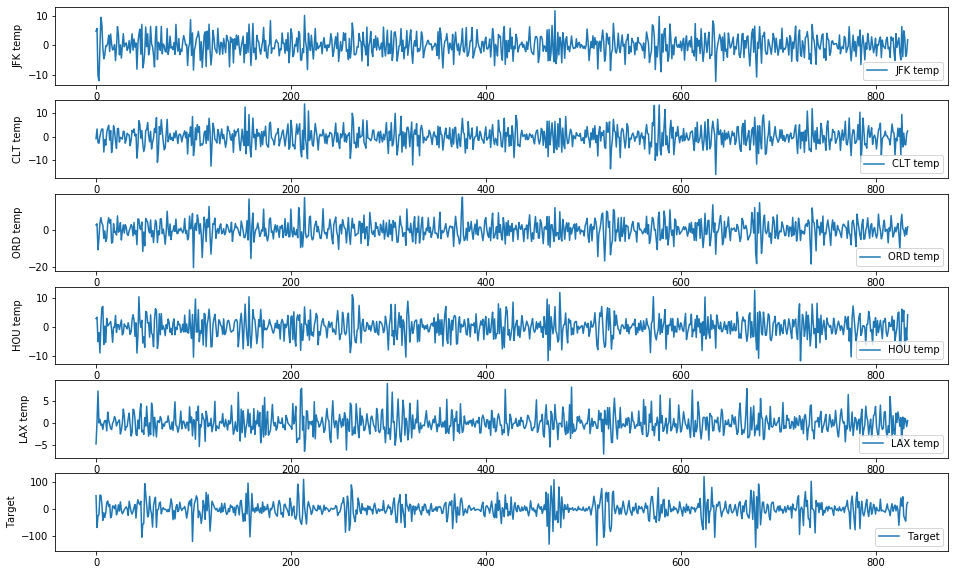

In [6]:
# Remove the trends
detrended_data = my_data[:,4:10] - datatrend

# Plot the trend fits
plt.figure(figsize=(16, 10))
names = ["JFK temp","CLT temp","ORD temp","HOU temp","LAX temp","Target"]
for k in range(0,6):
    plt.subplot(6,1,k+1)
    plt.plot(weeks, detrended_data[:,k])
    plt.legend([names[k]], loc='lower right')
    plt.ylabel(names[k])
plt.show()

Finally, we may consider the pairplot again for each pair of detrended signals. We observe that after detrending, all of our marginal distributions are roughly zero-mean.

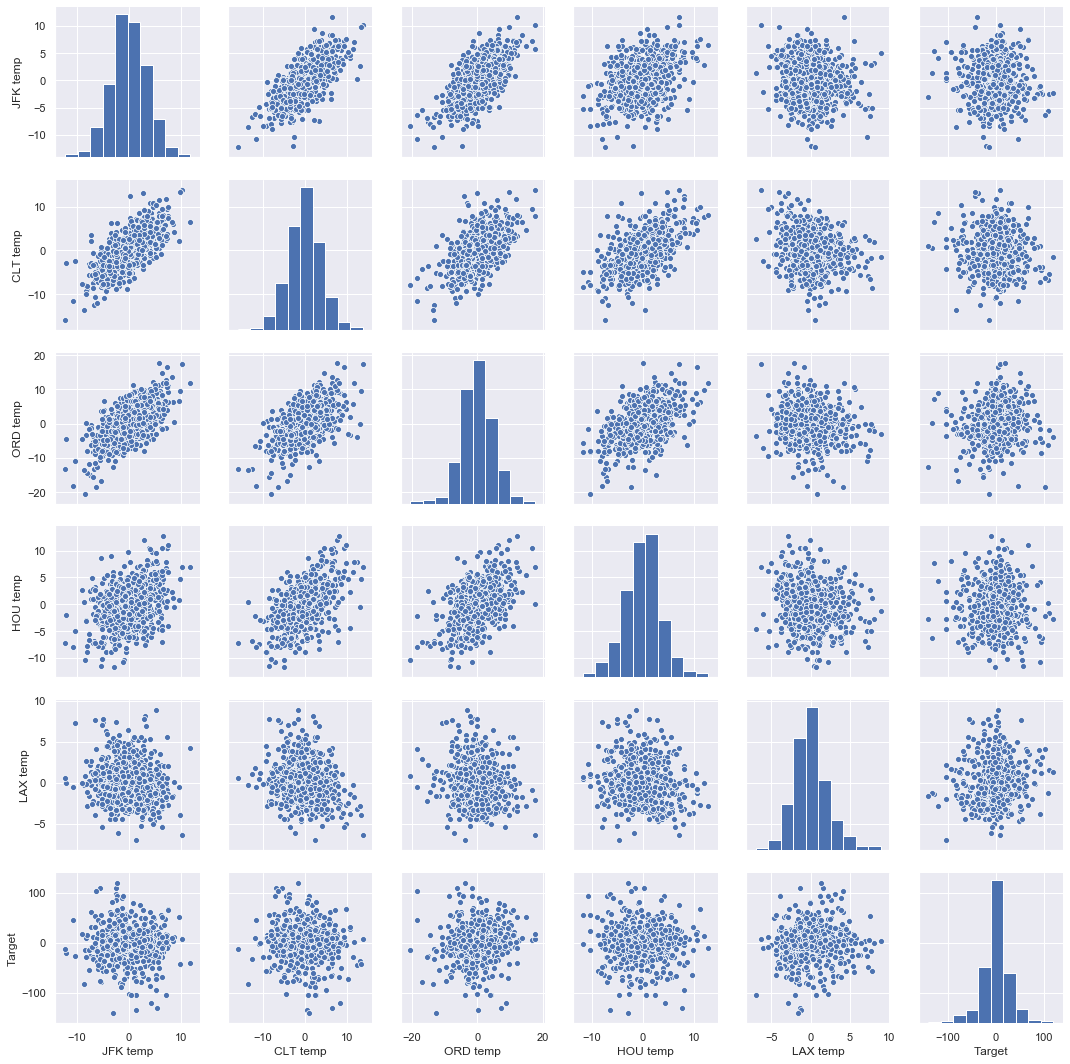

In [7]:
my_frame = pd.DataFrame(detrended_data,columns=names)
sns.set(rc={'figure.figsize':(7,7)})
sns.pairplot(my_frame, dropna=True)

## Linear correlation
Working with the detrended data now, we can ask questions about the result zero-mean processes. Are they normal? Are they correlated? In the pairplots above, most predictors do not have a linear correlation with the target. However, we observe some correlation between the airport temperatures, even after detrending. This indicates that we may consider some feature reduction if we apply a model, such as linear models, to this data set. In particular, principle component analysis (PCA) will be appropriate for any linear model we select.

Here, we show the resulting correlation plot given the above detrended pairplots. Note that this correlation is all instantaneous in time. Generalized cross-correlation may consider lags in time between signals, which will detect interactions between factors with a propagation delay.

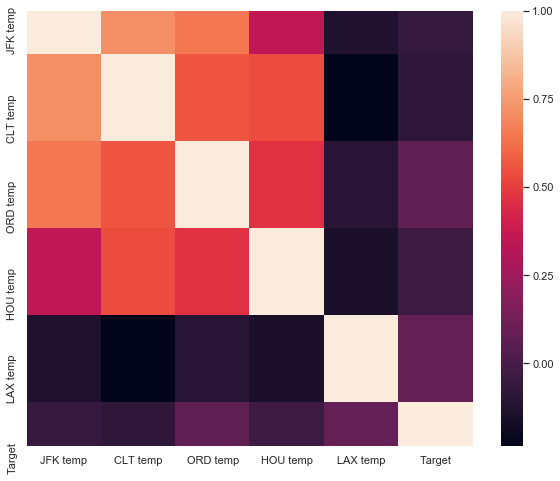

In [23]:
my_frame = pd.DataFrame(detrended_data,columns=names)
sns.set(rc={'figure.figsize':(10,8)})
sns.heatmap(my_frame.corr())